In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

In [2]:
SEED = 909
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_TEST = 16

IMAGE_HEIGHT = 400
IMAGE_WIDTH = 400
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = 'D:/SEM 7/Mini Project/Dataset/Train_Test/'
data_dir_train = os.path.join(data_dir, 'Training')
# The images should be stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'Image')
# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'GroundTruth')

data_dir_test = os.path.join(data_dir, 'Testing')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'Image')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'GroundTruth')

NUM_TRAIN = 1266
NUM_TEST = 630

NUM_OF_EPOCHS = 25


In [3]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    img_datagen = ImageDataGenerator(**data_gen_args)
    msk_datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = img_datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = img_datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [4]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 1266 images belonging to 1 classes.
Found 1266 images belonging to 1 classes.
Found 630 images belonging to 1 classes.
Found 630 images belonging to 1 classes.


In [5]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [6]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

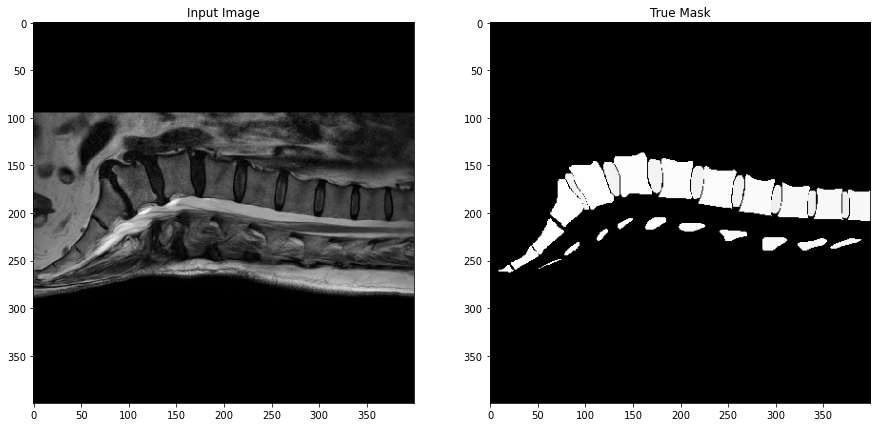

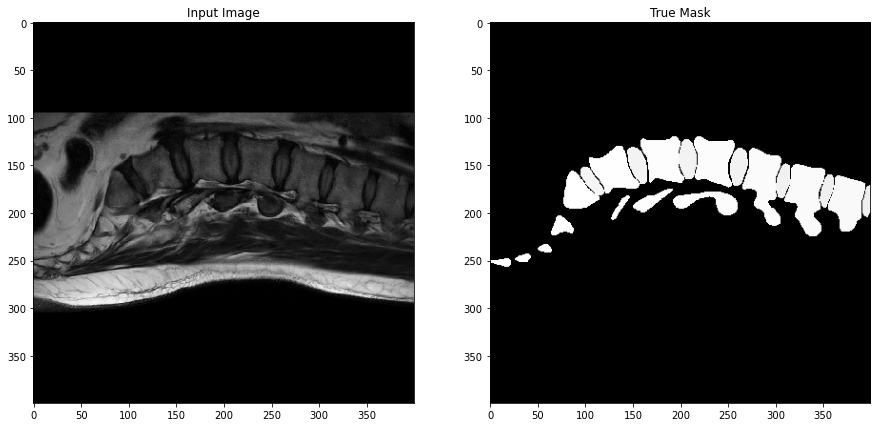

In [7]:
show_dataset(train_generator, 2)

In [8]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [9]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 200, 200, 32) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [11]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)

E:\Anaconda3.7\Anaconda\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
79/79 [==============================] - 1757s 22s/step - loss: 0.3090 - accuracy: 0.9039 - val_loss: 0.2835 - val_accuracy: 0.9046
Epoch 2/25
79/79 [==============================] - 1649s 21s/step - loss: 0.2183 - accuracy: 0.9158 - val_loss: 0.2202 - val_accuracy: 0.9047
Epoch 3/25
79/79 [==============================] - 1667s 21s/step - loss: 0.1923 - accuracy: 0.9156 - val_loss: 0.2663 - val_accuracy: 0.9048
Epoch 4/25
79/79 [==============================] - 1632s 21s/step - loss: 0.1944 - accuracy: 0.9157 - val_loss: 0.1745 - val_accuracy: 0.9047
Epoch 5/25
79/79 [==============================] - 1641s 21s/step - loss: 0.1480 - accuracy: 0.9108 - val_loss: 0.1487 - val_accuracy: 0.8884
Epoch 6/25
79/79 [==============================] - 1715s 22s/step - loss: 0.1125 - accuracy: 0.9072 - val_loss: 0.1165 - val_accuracy: 0.8964
Epoch 7/25
79/79 [==============================] - 1601s 20s/step - loss: 0.0854 - accuracy: 0.9120 - val_loss: 0.1019 - val_accuracy: 0.9062

In [12]:
model.save(f'UNET-SpineSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [13]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 630 images belonging to 1 classes.
Found 630 images belonging to 1 classes.


In [14]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

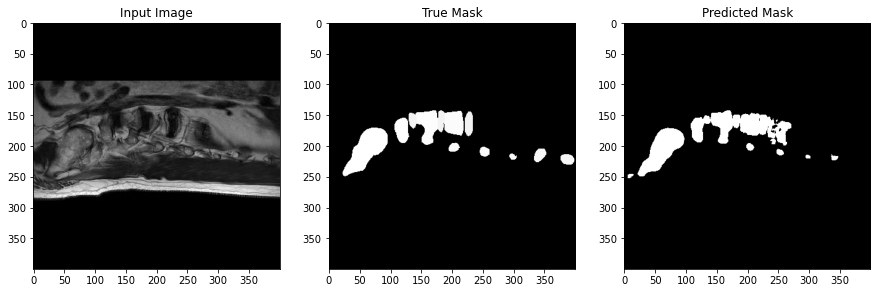

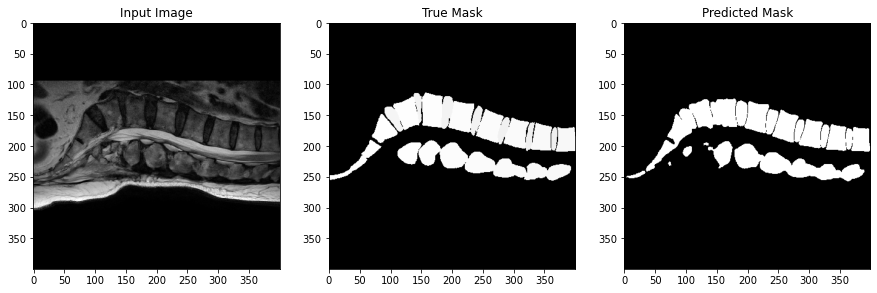

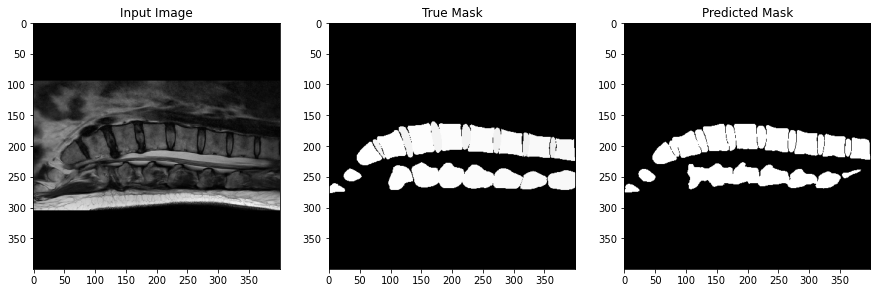

In [18]:
show_prediction(test_generator, 3)